In [1]:
import sys

sys.path.extend([".", ".."])

from analysis import hook_softmax_gelu, plot_dist, plot3d
from utils import datasets, net_wrap
from utils import parse_args, get_net, init_config, test_classification
from utils.quant_calib import QuantCalibrator, HessianQuantCalibrator

/home/master_112/nn6124030/.local/opt/miniconda3/envs/main/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fnet = get_net("vit_small_patch16_224")
g = datasets.ViTImageNetLoaderGenerator(
    root="/storage/share/datasets/ImageNet-1000/ILSVRC/Data/CLS-LOC",
    dataset_name="imagenet",
    train_batch_size=32,
    test_batch_size=1,
    num_workers=1,
    kwargs={"model": fnet},
)
test_loader = g.test_loader()

(12, 12)


100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


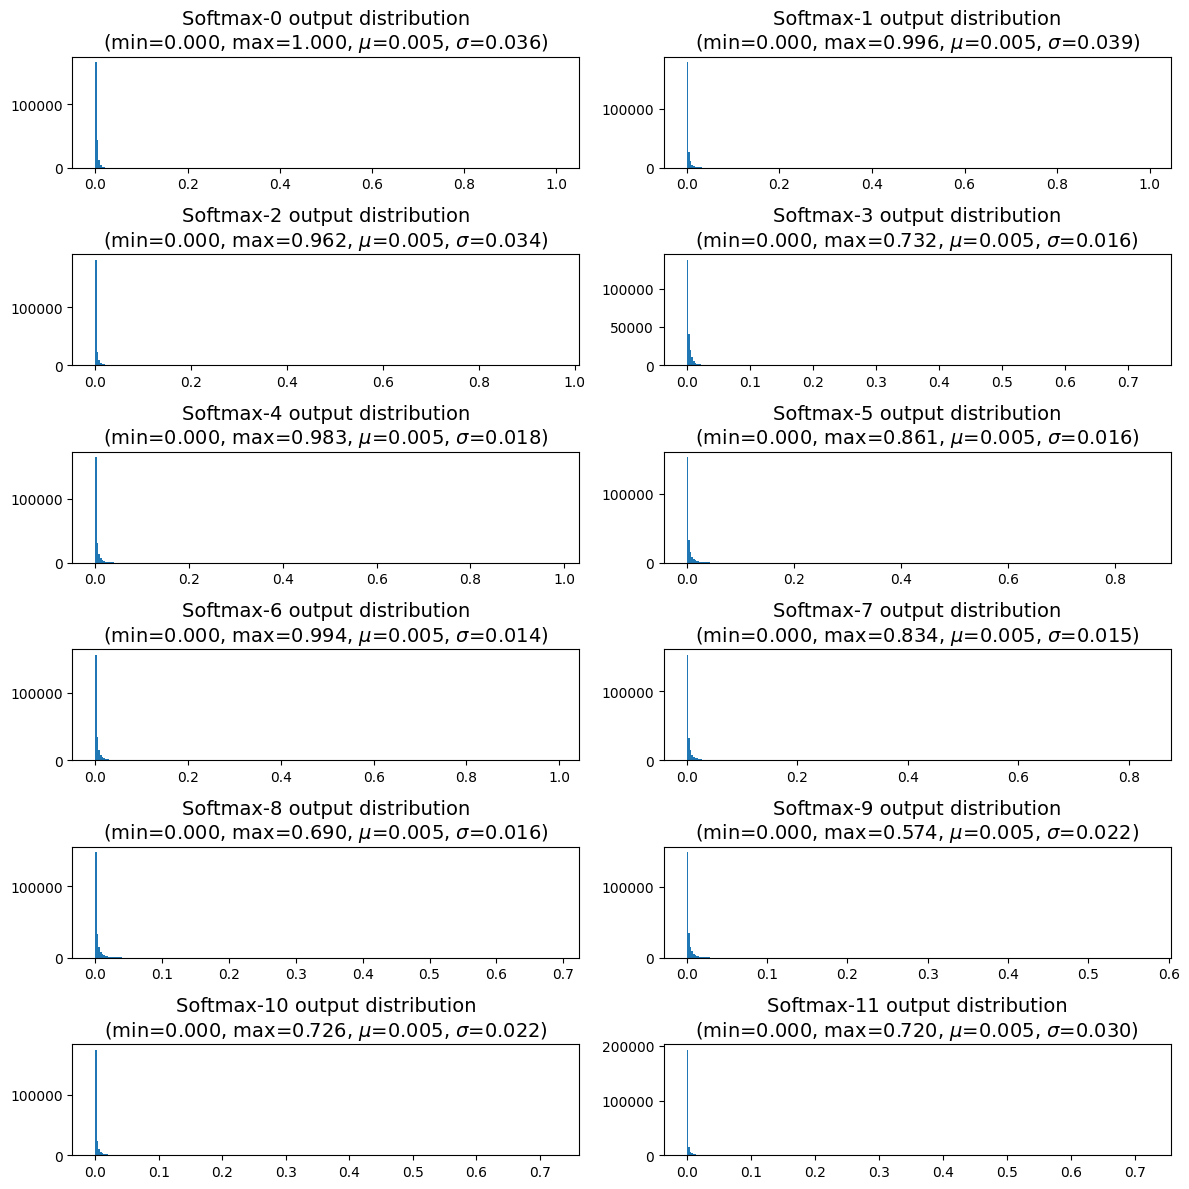

100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


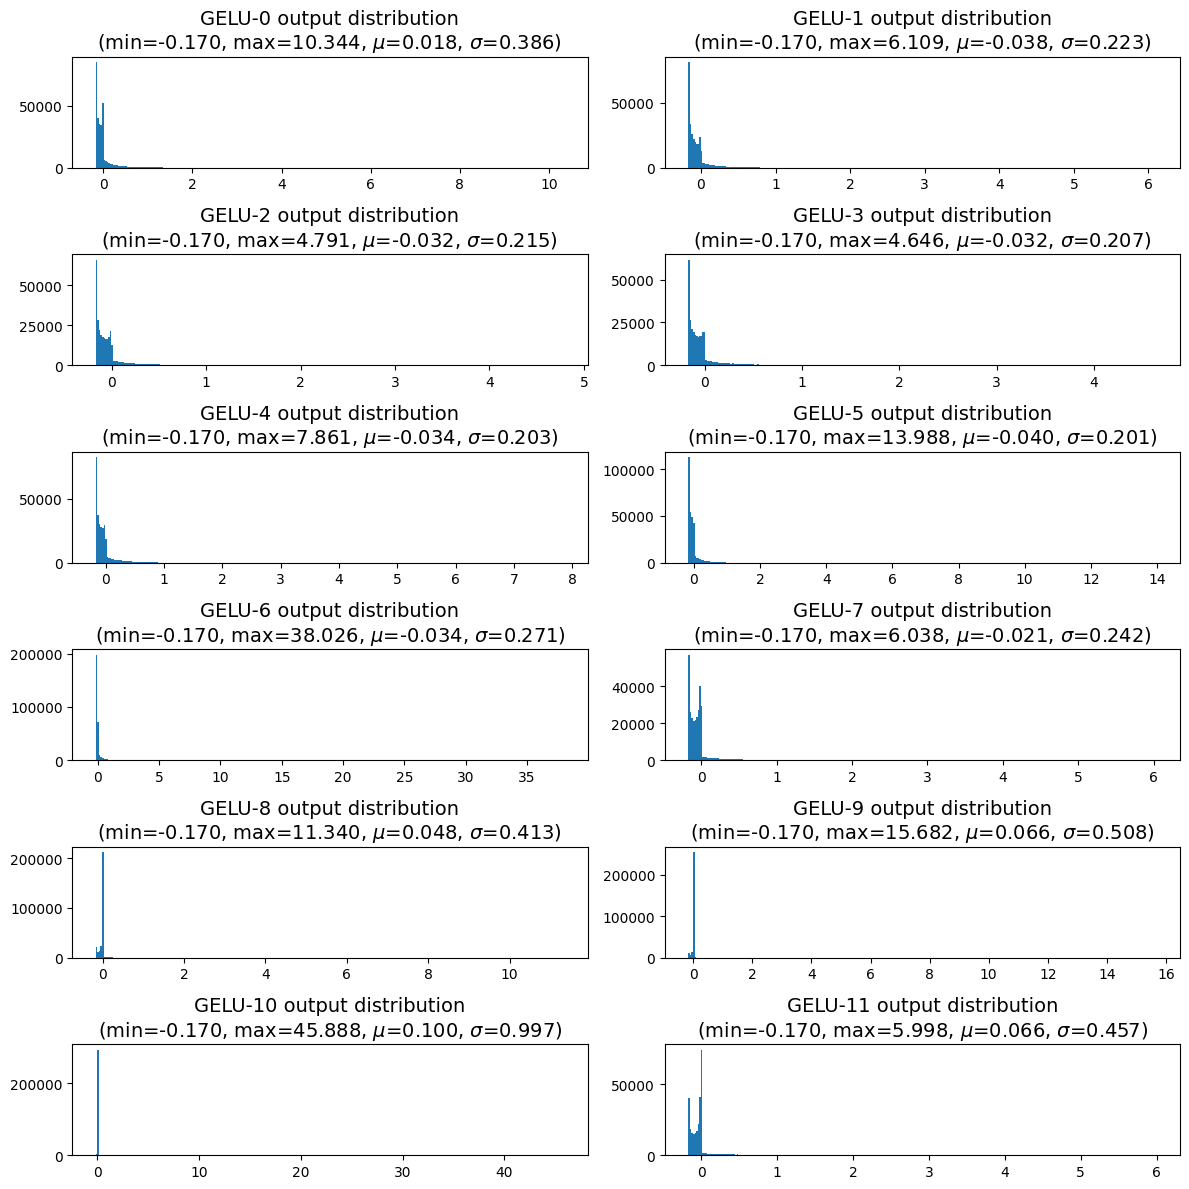

In [3]:
softmax_outputs, gelu_outputs = hook_softmax_gelu(fnet)

x = next(iter(test_loader))[0]
fnet(x)

print(f'{len(softmax_outputs), len(gelu_outputs)}')

plot_dist(softmax_outputs, title="Softmax")
plot_dist(gelu_outputs, title="GELU")

In [5]:
def quantize(net):
    qconfig = init_config("PTQ4ViT")
    wrapped_modules = net_wrap.wrap_modules_in_net(net, qconfig)

    g = datasets.ViTImageNetLoaderGenerator(
        root="/storage/share/datasets/ImageNet-1000/ILSVRC/Data/CLS-LOC",
        dataset_name="imagenet",
        train_batch_size=32,
        test_batch_size=1,
        num_workers=1,
        kwargs={"model": fnet},
    )
    calib_loader = g.calib_loader(num=32)

    quant_calibrator = HessianQuantCalibrator(
        net, wrapped_modules, calib_loader, sequential=False, batch_size=4
    )  # 16 is too big for ViT-L-16
    quant_calibrator.batching_quant_calib()

    # test_classification(net, test_loader)
    return net

# calib_loader = g.calib_loader(num=32)
qnet = quantize(fnet.cuda())
qnet

Completed net wrap.
prepare parallel calibration for ['patch_embed.proj', 'blocks.0.attn.qkv', 'blocks.0.attn.proj', 'blocks.0.mlp.fc1', 'blocks.0.mlp.fc2', 'blocks.1.attn.qkv', 'blocks.1.attn.proj', 'blocks.1.mlp.fc1', 'blocks.1.mlp.fc2', 'blocks.2.attn.qkv', 'blocks.2.attn.proj', 'blocks.2.mlp.fc1', 'blocks.2.mlp.fc2', 'blocks.3.attn.qkv', 'blocks.3.attn.proj', 'blocks.3.mlp.fc1', 'blocks.3.mlp.fc2', 'blocks.4.attn.qkv', 'blocks.4.attn.proj', 'blocks.4.mlp.fc1', 'blocks.4.mlp.fc2', 'blocks.5.attn.qkv', 'blocks.5.attn.proj', 'blocks.5.mlp.fc1', 'blocks.5.mlp.fc2', 'blocks.6.attn.qkv', 'blocks.6.attn.proj', 'blocks.6.mlp.fc1', 'blocks.6.mlp.fc2', 'blocks.7.attn.qkv', 'blocks.7.attn.proj', 'blocks.7.mlp.fc1', 'blocks.7.mlp.fc2', 'blocks.8.attn.qkv', 'blocks.8.attn.proj', 'blocks.8.mlp.fc1', 'blocks.8.mlp.fc2', 'blocks.9.attn.qkv', 'blocks.9.attn.proj', 'blocks.9.mlp.fc1', 'blocks.9.mlp.fc2', 'blocks.10.attn.qkv', 'blocks.10.attn.proj', 'blocks.10.mlp.fc1', 'blocks.10.mlp.fc2', 'blocks.1

Hessian:   0%|          | 0/50 [00:00<?, ?it/s, patch_embed.proj]/home/master_112/nn6124030/.local/opt/miniconda3/envs/main/lib/python3.8/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Hessian: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it, head]               


hessian calibration finished


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): ChannelwiseBatchingQuantConv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): PTQSLBatchingQuantLinear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): PTQSLBatchingQuantLinear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
        (matmul1): PTQSLBatchingQuantMatMul()
        (matmul2): SoSPTQSLBatchingQuantMatMul()
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): PTQSLBatchi

(5220, 5244)


100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


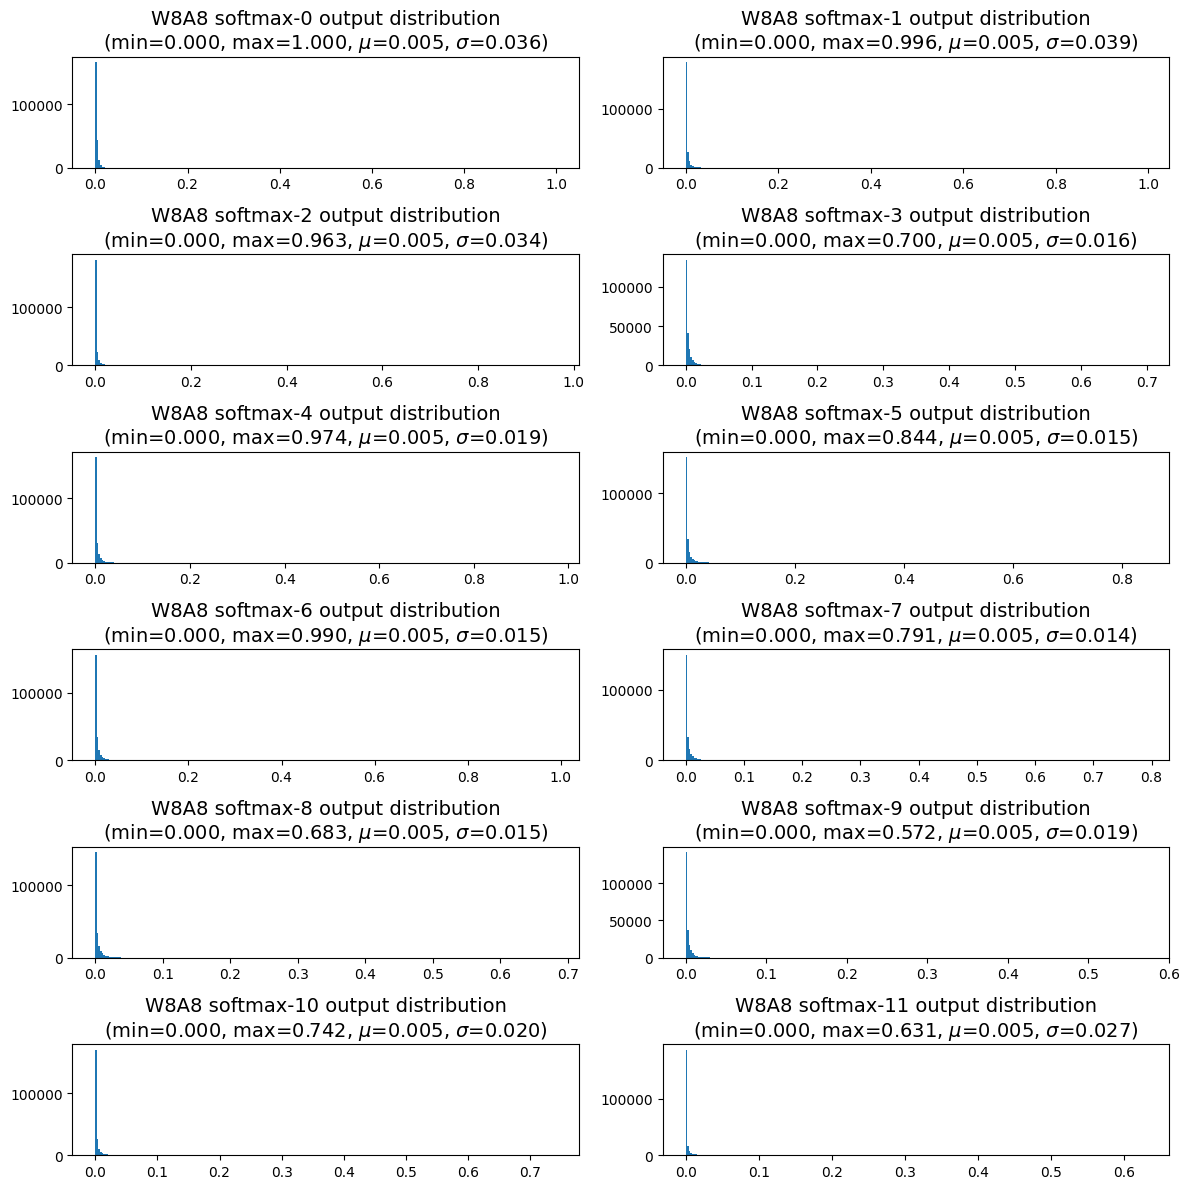

100%|██████████| 12/12 [00:14<00:00,  1.22s/it]


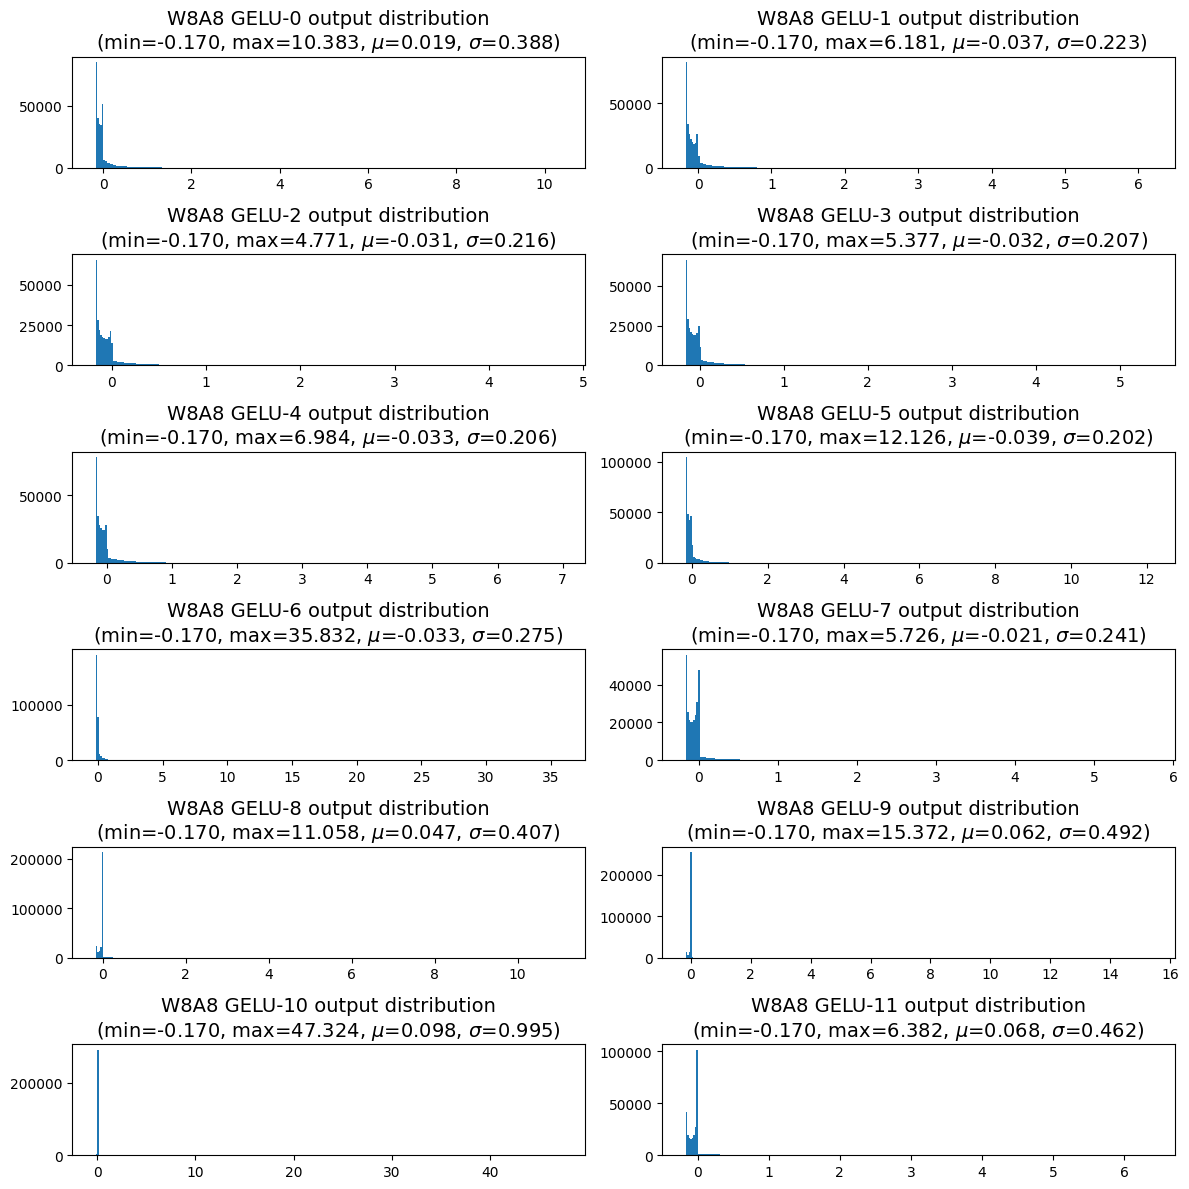

In [7]:
q8_softmax_outputs, q8_gelu_outputs = hook_softmax_gelu(qnet)
qnet.cuda()(x.cuda())

print(f'{len(softmax_outputs), len(gelu_outputs)}')

plot_dist(q8_softmax_outputs, title="W8A8 softmax")
plot_dist(q8_gelu_outputs, title="W8A8 GELU")

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot3d(data, figsize=(10, 7), title="", cmap="coolward", elev=30, azim=120, path=None):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")

    # Plot the surface
    patches, channels = np.arange(data.shape[1]), np.arange(data.shape[0])
    patches, channels = np.meshgrid(patches, channels)
    surf = ax.plot_surface(patches, channels, data, cmap=cmap, edgecolor="none")

    # Set axis labels
    ax.set_xlabel("Channel")
    ax.set_ylabel("Patch")
    ax.set_zlabel("Value")
    ax.set_title(title, fontsize=20)

    # Customize the view angle
    ax.view_init(elev=elev, azim=azim)

    # Add a color bar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label("Value")

    # Show/save the plot
    plt.tight_layout()
    if path is not None:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path)
    plt.show()


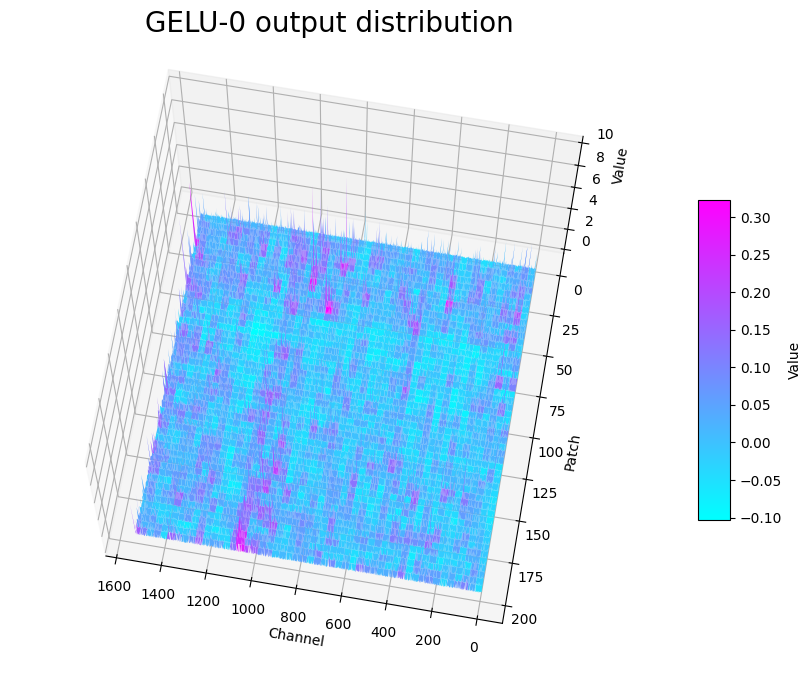

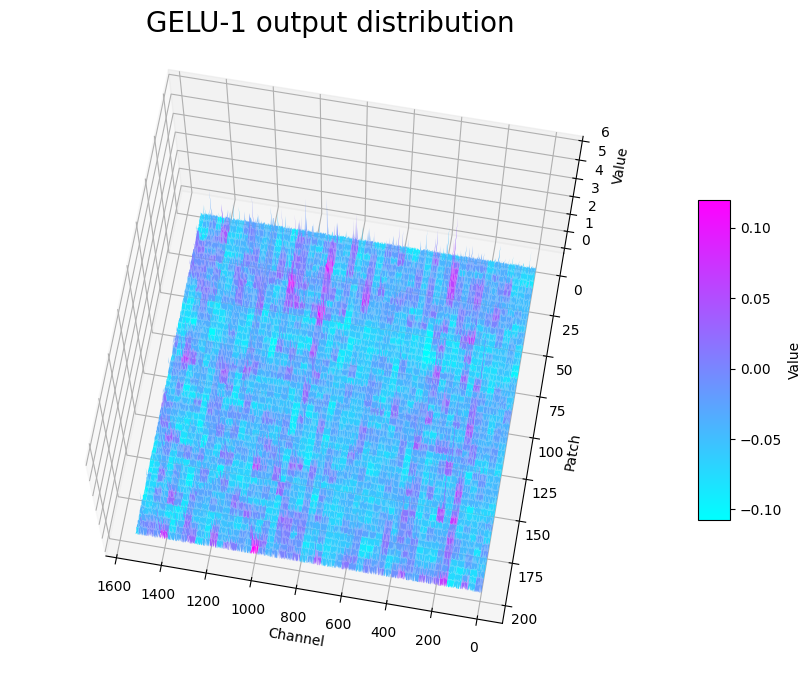

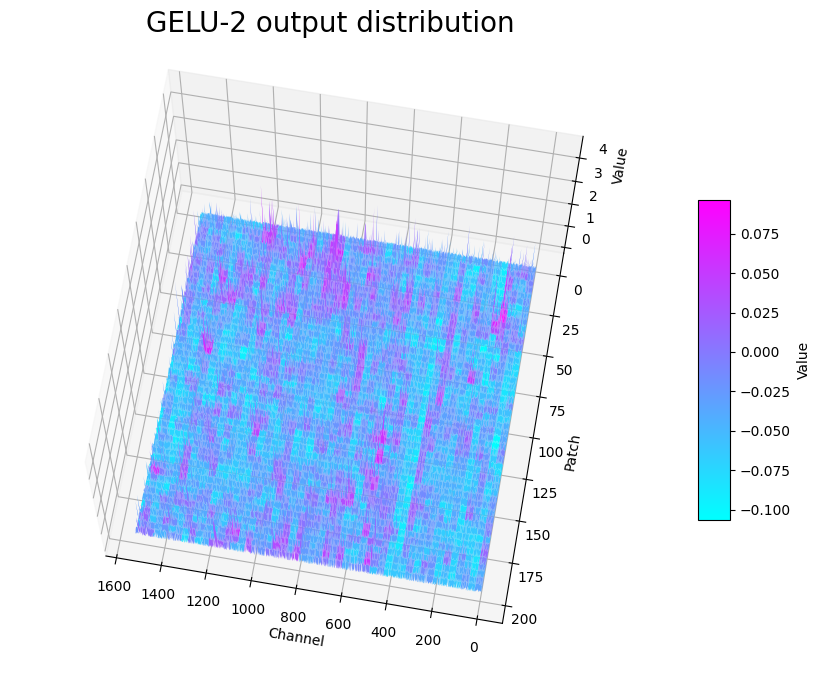

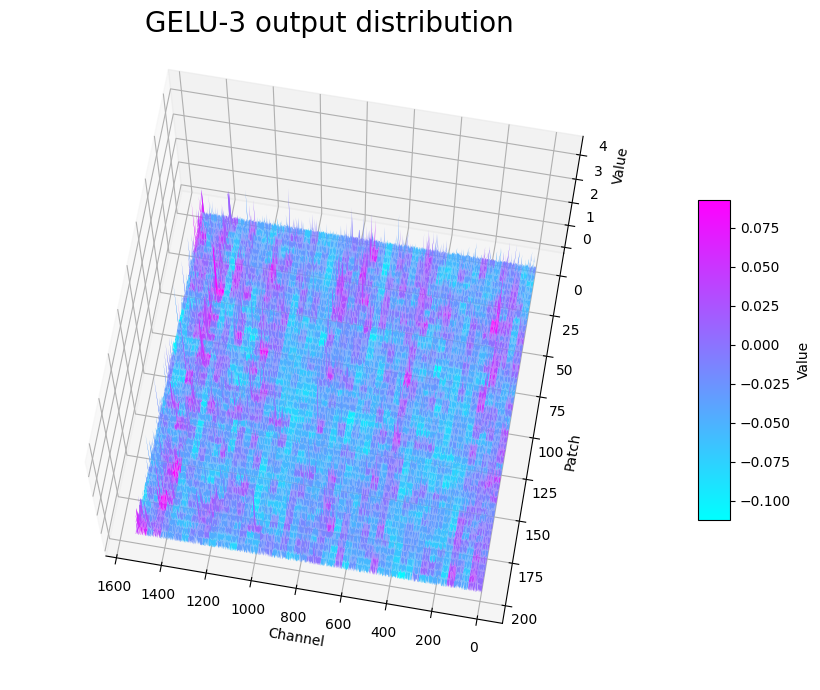

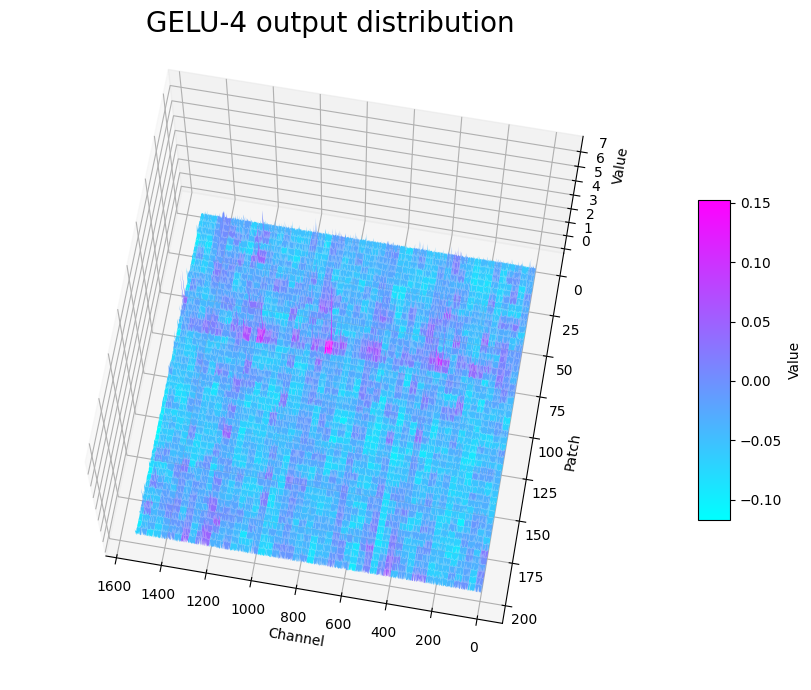

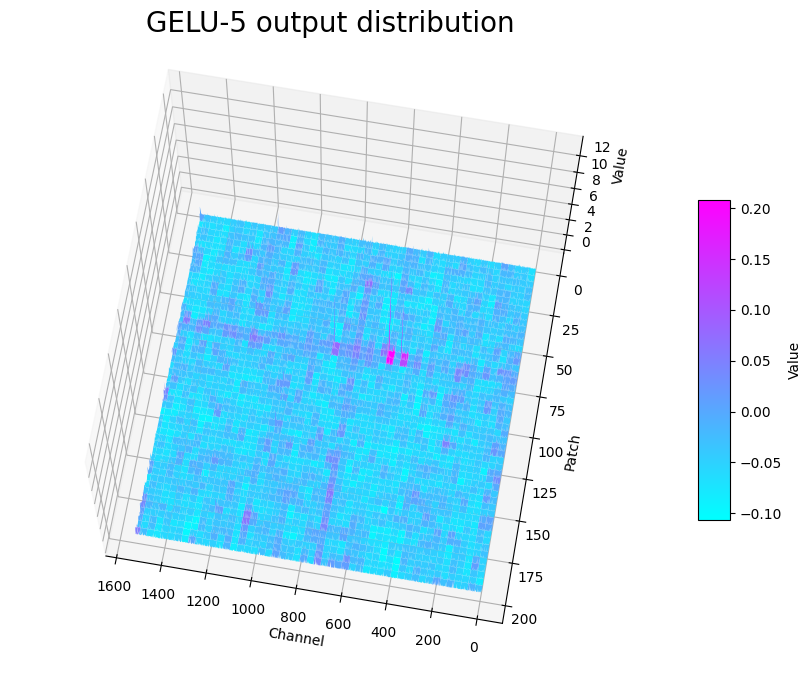

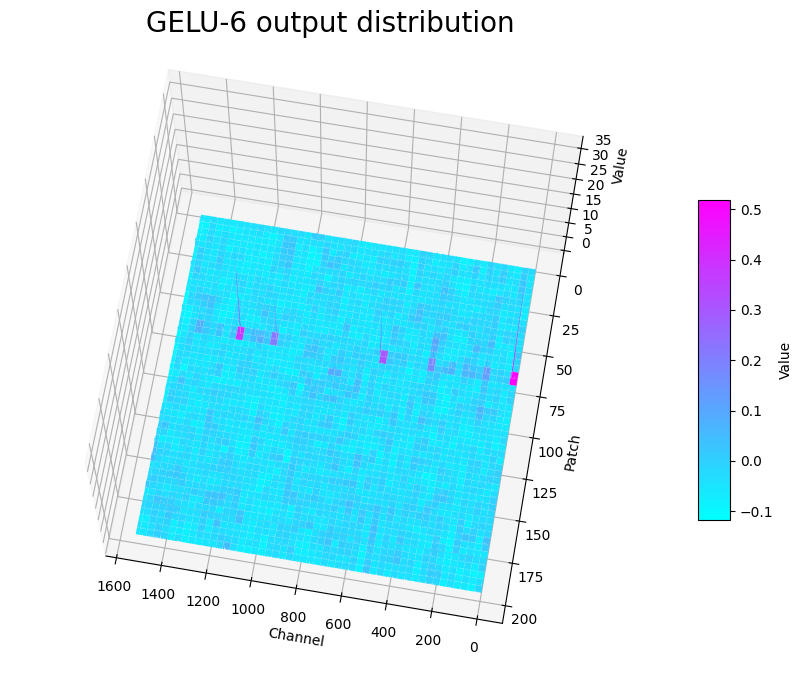

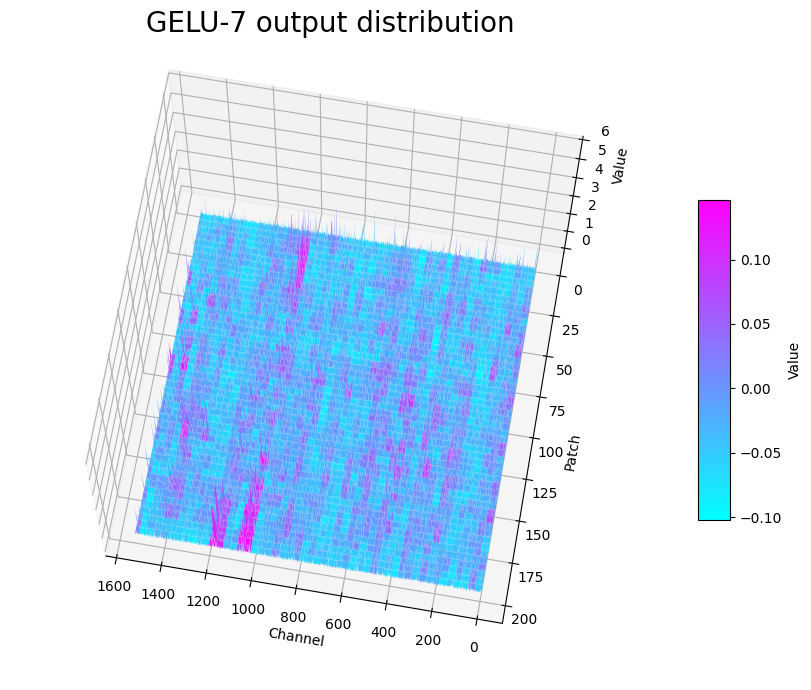

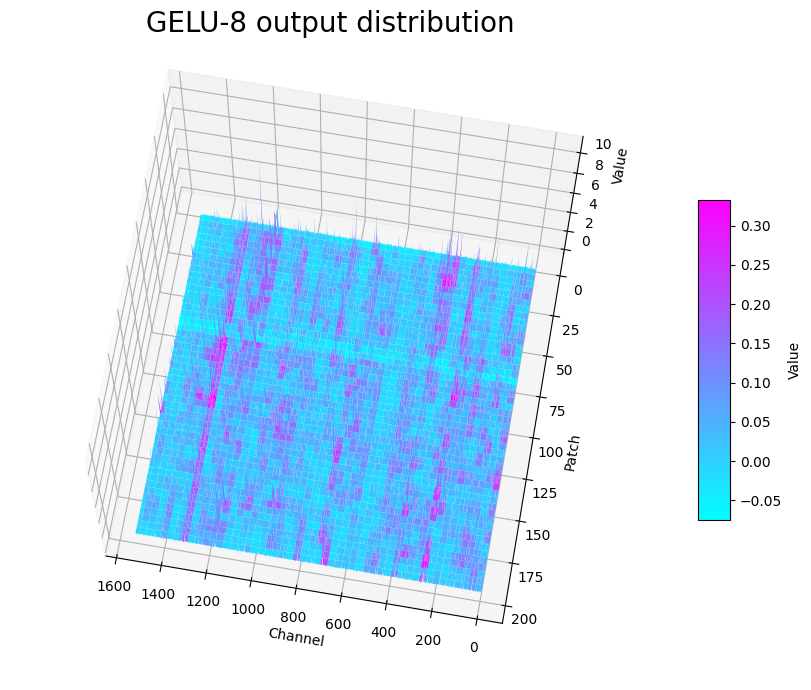

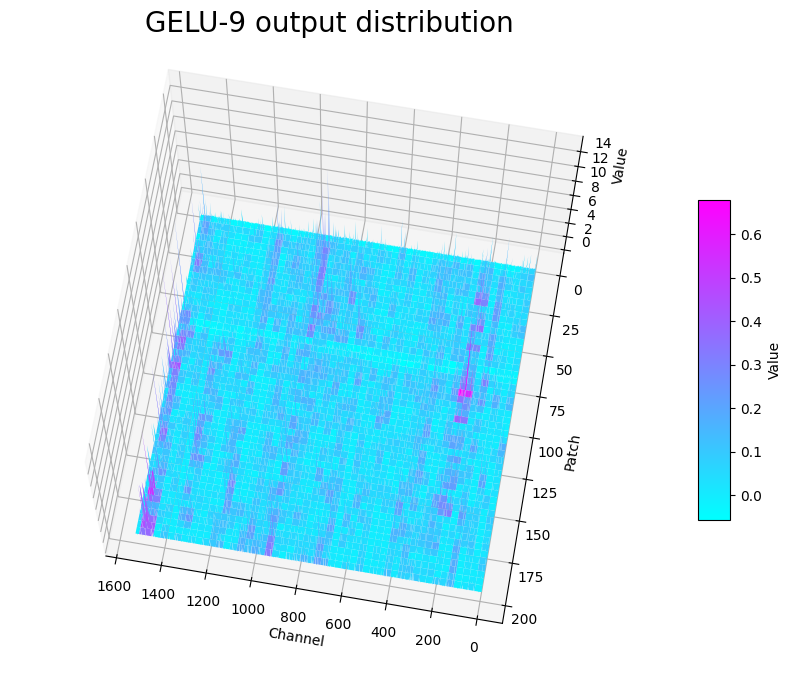

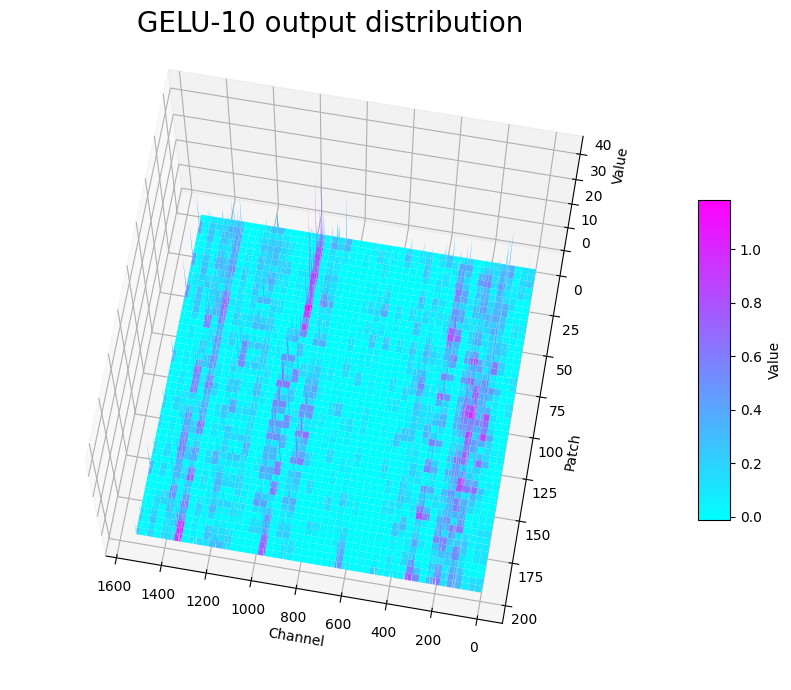

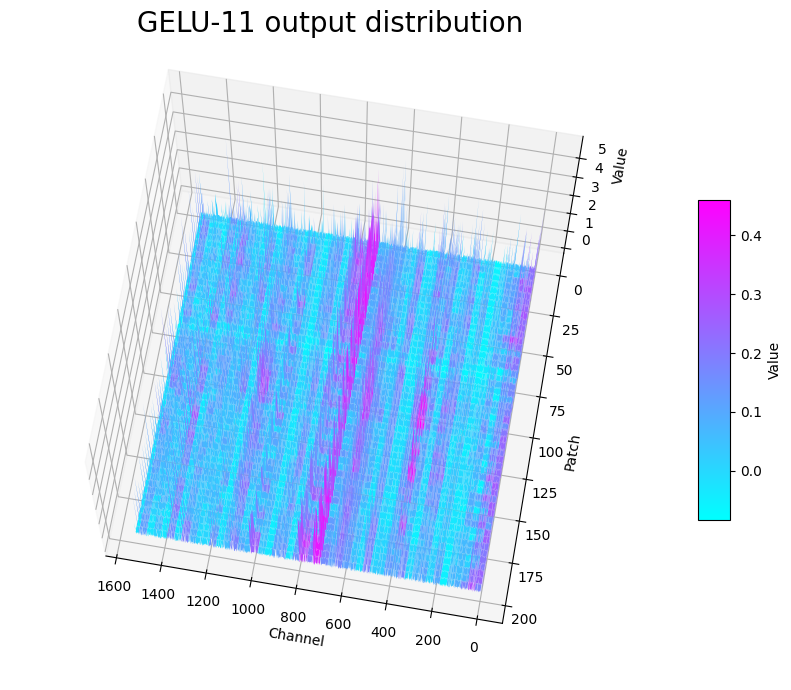

In [29]:
for i in range(12):
    plot3d(gelu_outputs[i][0], title=f"GELU-{i} output distribution", elev=70, azim=100, figsize=(10, 7), cmap="cool")
    # plot3d(q8_gelu_outputs[i][0], figsize=(10, 7), cmap="cool")

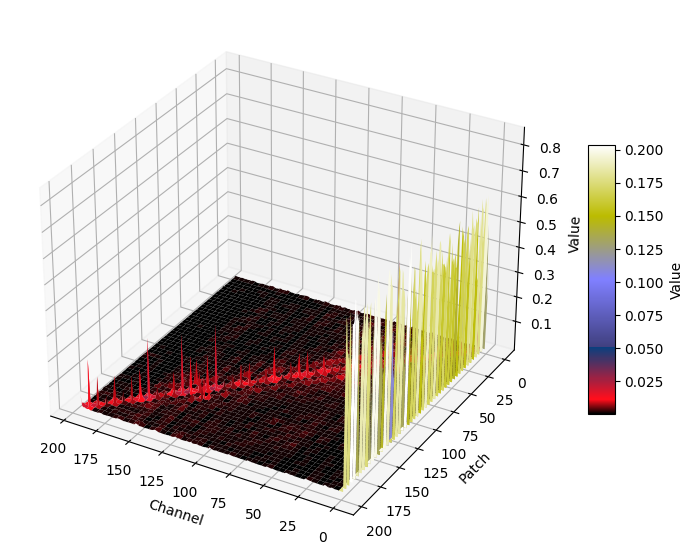

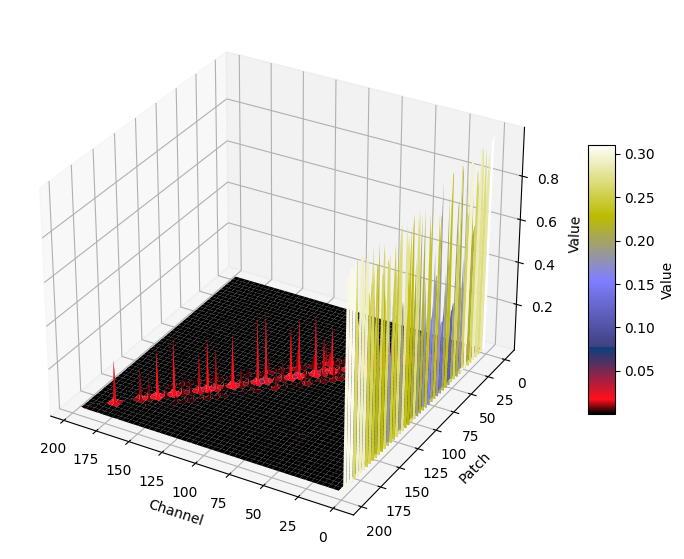

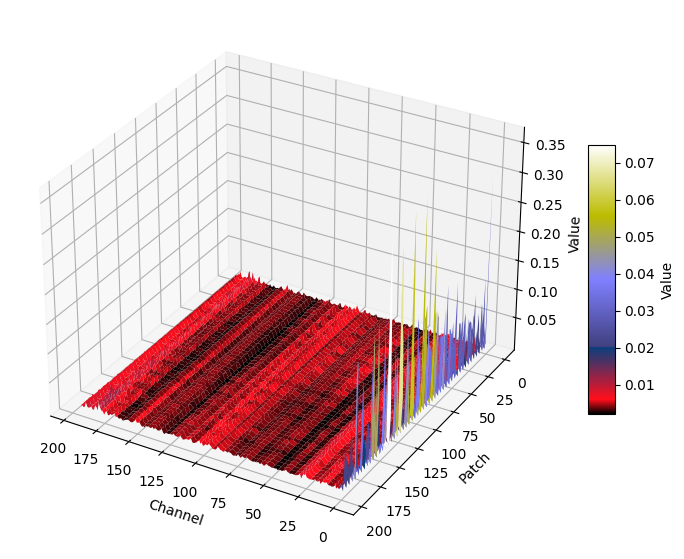

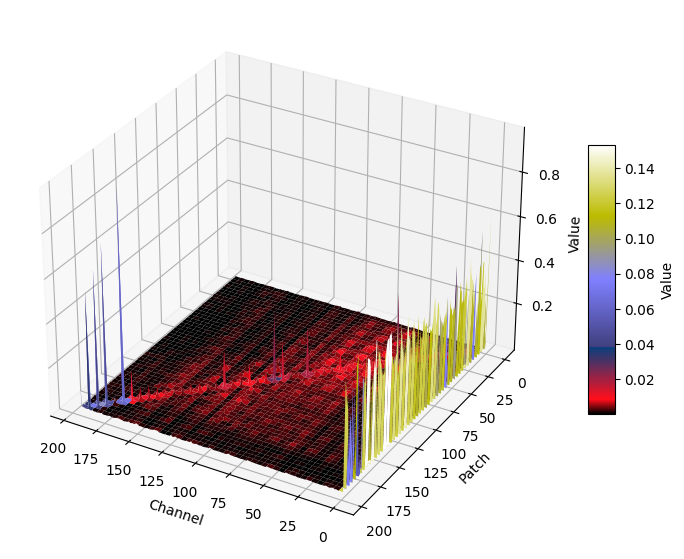

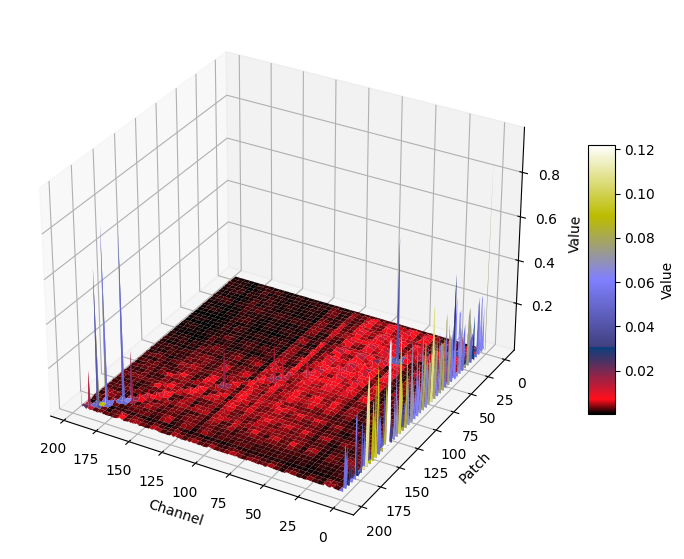

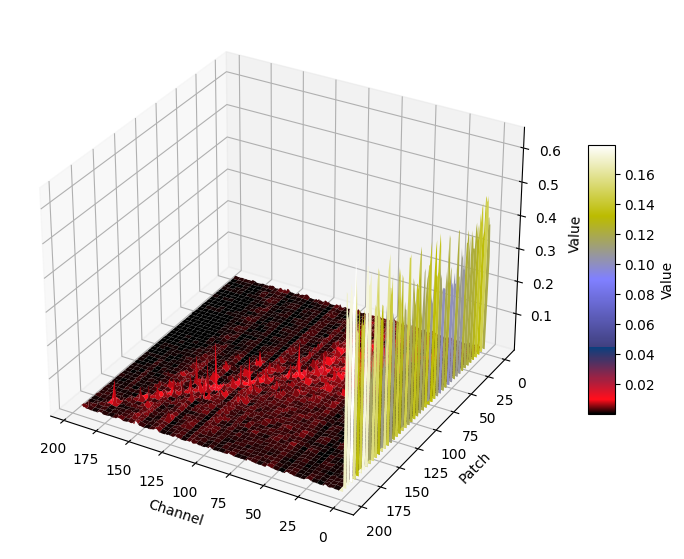

In [147]:

for x in softmax_outputs[0][0]:
    plot3d(x, cmap="gist_stern")